In [94]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [95]:
import datetime as dt

In [96]:
from sklearn.neighbors import KNeighborsRegressor

In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [98]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix 
from sklearn.metrics import classification_report, precision_recall_curve, auc

# PART 1

In [99]:
# load as Pandas dataframe
df = pd.read_json('logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [100]:
df.shape

(93142, 1)

In [101]:
#checking for null values

print('NANs:' + str(df['login_time'].isnull().sum()))

NANs:0


In [102]:
df['login_time'] = pd.to_datetime(df['login_time'], format='%Y-%m-%d %H:%M:%S')

df['count'] = 1

In [103]:
df.head()

,login_time,count
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


In [104]:
#aggregate by 15 minute increments
df.set_index('login_time', inplace = True)

#New dataframe of 15 minutes increments
increment = df.resample('15T').sum()

increment.tail()

,count
login_time,
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2
1970-04-13 18:30:00,7
1970-04-13 18:45:00,6


In [105]:
increment.shape

(9788, 1)

In [106]:
increment_groups = increment.groupby(increment.index.time)["count"].mean().reset_index()

print(increment_groups.head())

      index      count
0  00:00:00  14.107843
1  00:15:00  15.166667
2  00:30:00  14.950980
3  00:45:00  14.529412
4  01:00:00  15.186275


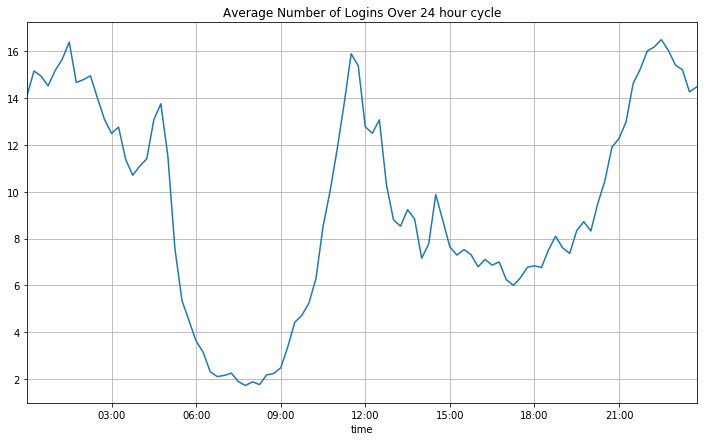

In [107]:
increment_groups.columns = ["time", "count" ]

# daily cycle
increment_groups.plot(x = "time", y = "count", figsize = (12,7), legend = False, grid = True, 
                      xticks = ['03:00:00', '6:00', '9:00', '12:00:00', '15:00', '18:00', '21:00'], 
                      title = "Average Number of Logins Over 24 hour cycle")

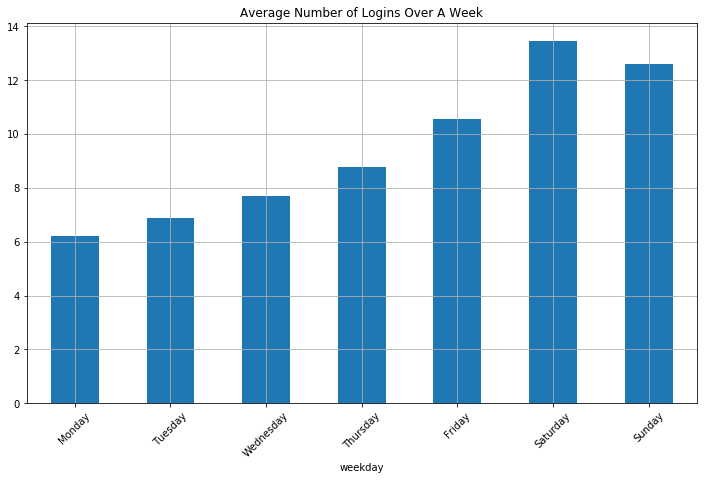

In [108]:
week_cycle = increment.groupby(increment.index.weekday)["count"].mean().reset_index()

week_cycle.columns = ["day", "count" ]

dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
week_cycle['weekday'] = week_cycle['day'].map(dayOfWeek)

week_cycle.plot(kind = 'bar', x = "weekday", y = "count", figsize = (12,7), legend = False, grid = True, 
                      title = "Average Number of Logins Over A Week", rot = 45)

# PART 2

<div class="span5 alert alert-info">
 
<p>1) My key measure of success would be average ride price (per mile) during peak times of each city. Covering drivers' road tolls should increase drivers' sensitivity to demand changes. Increased supply of drivers should drive down the equilibrium price, provided demand does not change.

2a) I would pick a month with no holidays or three-day weekends to run an experiment. First two weeks would be with no tolls covered. Last two weeks would be with tolls covered.  

2b) Statistical Test would be Difference in Means for two time periods.

2c) I would compare increased costs (resulting from toll coverage) against the increased revenue from increased number of rides. Revenue increase would be attenuated by the decrease in prices from larger supply.
</p>
</div>

# PART 3

In [109]:
data = pd.DataFrame(json.load((open('ultimate_data_challenge.json'))))

In [110]:
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


## Pre-processing

In [112]:
#convert from string to date objects

data['last_trip_date'] = pd.to_datetime(data['last_trip_date'], format='%Y-%m-%d')
data['signup_date'] = pd.to_datetime(data['signup_date'], format='%Y-%m-%d')

In [113]:
#reference point for last 30 days
end_date = data['last_trip_date'].max()

#users are considered 'active' if they had trips on this date or afterwards
active_start = end_date - pd.Timedelta(30, unit='D')

print(active_start)

2014-06-01 00:00:00


In [114]:
#define active users
data['active'] = np.where(data['last_trip_date'] >= active_start, 1, 0)

print ('Proportion of users that are active: ' + str(np.round(data['active'].sum() / len(data.index), 2)))

Proportion of users that are active: 0.38


In [115]:
print("Unique values of Ultimate Black: " + str(data['ultimate_black_user'].unique()))

Unique values of Ultimate Black: [ True False]


In [116]:
#convert boolean values to 1's and 0's
data['ultimate_black_user'] = data['ultimate_black_user'].astype(int)

In [117]:
print(data['city'].unique())

["King's Landing" 'Astapor' 'Winterfell']


In [118]:
print(data['phone'].unique())

['iPhone' 'Android' None]


In [119]:
#convert categorical values to dummy variables
data2 = pd.get_dummies(data, columns=['city', 'phone'], drop_first = True)
print(data2.columns)

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'last_trip_date', 'signup_date', 'surge_pct', 'trips_in_first_30_days',
       'ultimate_black_user', 'weekday_pct', 'active', 'city_King's Landing',
       'city_Winterfell', 'phone_iPhone'],
      dtype='object')


## SOME EDA

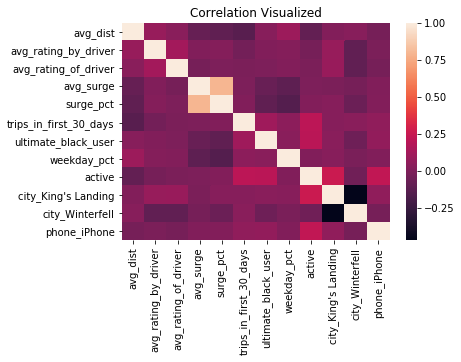

<Figure size 720x504 with 0 Axes>

In [120]:
#Plot correlation matrix

ax = plt.axes()
corr = data2.corr()

sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, ax = ax)

ax.set_title('Correlation Visualized')
plt.figure(figsize=(10,7))
plt.show()

In [121]:
#helper functions to convert values
def convert(value):
    if value == 1:
        return 'Yes'
    elif value == 0:
        return 'No'

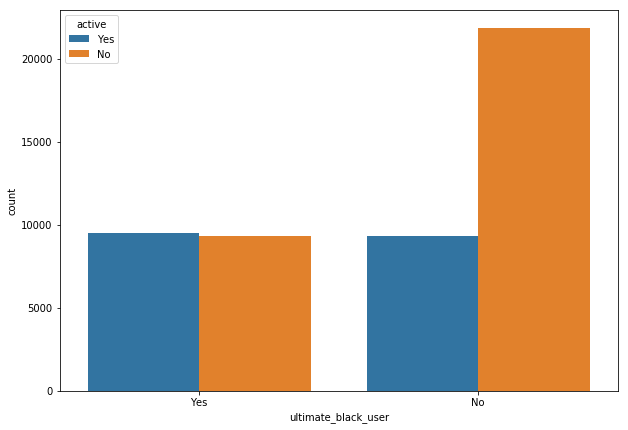

In [122]:
test = data2.loc[: , ["ultimate_black_user","active"]]

test["active"] = test["active"].apply(convert)
test["ultimate_black_user"] = test["ultimate_black_user"].apply(convert)

plt.figure(figsize=(10,7))
sns.countplot(x="ultimate_black_user", hue="active", data=test)

plt.show()

## Pre- processing (cont'd)

In [123]:
#first drop time stamp variables
data3 = data2.drop(['last_trip_date', 'signup_date'], axis = 1)

cols = list(data3.columns)
print(cols)

['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct', 'active', "city_King's Landing", 'city_Winterfell', 'phone_iPhone']


In [124]:
#move target variable and imputed column to the front for ease of manipulation for knn imputation

imputecolumn = cols[2]   # 'avg_rating_of_driver'
cols.insert(0, cols.pop(cols.index(imputecolumn)))

target_col = cols[8]    #'active'
cols.insert(0, cols.pop(cols.index(target_col)))

print(cols)

['active', 'avg_rating_of_driver', 'avg_dist', 'avg_rating_by_driver', 'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct', "city_King's Landing", 'city_Winterfell', 'phone_iPhone']


## Imputation of missing values

In [125]:
#reaggranged dataframe

data4 = data3[cols]

#impute median values by respective column 

data4['avg_rating_by_driver'].fillna(data4['avg_rating_by_driver'].median(), inplace=True)
data4['phone_iPhone'].fillna(data4['phone_iPhone'].median(), inplace= True)

C:\Users\airshu23\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\airshu23\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


<div class="span5 alert alert-info">
<p> The code below involves a bunch of numpy manipulation to get the right format to use KNN to impute values for 'average rating of driver'. First I separate rows with missing values from those with no missing values for 'average rating of driver'. This serves as the train and test sets for imputation. Next I remove target variable 'active' so that the imputed variable is determined only by other features in the dataset. After using KNN to get imputed values, I reassemble the original dataframe. </p>
</div>

In [126]:
# break up NANs vs non-NANs

missing = data4[data4['avg_rating_of_driver'].isna() == 1]
not_missing = data4[data4['avg_rating_of_driver'].isna() == 0]

print (missing.shape)
print (not_missing.shape)

(8122, 12)
(41878, 12)


In [127]:
#split into features and target of imputation ('average rating of driver') for rows without missing values

train_x = not_missing[not_missing.columns[~not_missing.columns.isin(['avg_rating_of_driver', 'active'])]].values
train_y = not_missing['avg_rating_of_driver'].values


#features of rows with missing 'averagre rating of driver' values

missing_x = missing[missing.columns[~missing.columns.isin(['avg_rating_of_driver', 'active'])]].values     

In [128]:
# initiate KNN
clf = KNeighborsRegressor(10, weights='distance')

#use observations with no missing values to train model
trained_model = clf.fit(train_x, train_y)  

# impute missing values for 'average rating of driver' 
imputed_average_rating_of_driver = trained_model.predict(missing_x)

# Join column of imputed values with associated features
X_with_imputed = np.hstack((imputed_average_rating_of_driver.reshape(-1,1), missing_x))

#add target ('active') column to X_with_imputed
all_missing = np.hstack((missing['active'].values.reshape(-1,1), X_with_imputed))

# Join two feature matrices so that imputed and non-imputed observations are combined
combined = np.vstack((not_missing, all_missing))

final_features= pd.DataFrame(data=combined, columns=data4.columns)

In [129]:
final_features.head()

,active,avg_rating_of_driver,avg_dist,avg_rating_by_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,city_King's Landing,city_Winterfell,phone_iPhone
0,1.0,4.7,3.67,5.0,1.10,15.4,4.0,1.0,46.2,1.0,0.0,1.0
1,0.0,5.0,8.26,5.0,1.00,0.0,0.0,0.0,50.0,0.0,0.0,0.0
2,0.0,4.3,0.77,5.0,1.00,0.0,3.0,0.0,100.0,0.0,0.0,1.0
3,1.0,4.6,2.36,4.9,1.14,20.0,9.0,1.0,80.0,1.0,0.0,1.0
4,0.0,4.4,3.13,4.9,1.19,11.8,14.0,0.0,82.4,0.0,1.0,0.0


## Model Building

In [130]:
X = final_features.drop('active', axis = 1)
y = final_features['active']

In [131]:
#split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=77)

In [132]:
X_const = sm.add_constant(X_train)
logit_model= sm.Logit(y_train, X_const)
result=logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.558117
         Iterations 6


C:\Users\airshu23\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [133]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Pseudo R-squared:   0.158     
Dependent Variable:   active             AIC:                44673.3472
Date:                 2019-04-09 16:29   BIC:                44776.5068
No. Observations:     40000              Log-Likelihood:     -22325.   
Df Model:             11                 LL-Null:            -26518.   
Df Residuals:         39988              LLR p-value:        0.0000    
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       6.0000                                           
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
const                  -1.1133   0.1734  -6.4209 0.0000 -1.4531 -0.7735
avg_rating_of_driver   -0.0566   0.0197  -2.8758 0.0040 -0.0952 -0.0180
avg_dist               -0.0366   0.0023 -15.7508 0.0000 -0.0411 -0.0320
avg_rating_by_driver   -0.1579   0.0257  -6.1481 0.0000 -0.2083 -0.1076
avg_surge              -0.1744   0.0877  -1.9881 0.0468 -0.3463 -0.0025
surge_pct               0.0037   0.0010   3.8533 0.0001  0.0018  0.0057
trips_in_first_30_days  0.1182   0.0039  30.6487 0.0000  0.1106  0.1258
ultimate_black_user     0.8738   0.0238  36.6757 0.0000  0.8271  0.9205
weekday_pct            -0.0004   0.0003  -1.3210 0.1865 -0.0011  0.0002
city_King's Landing     1.7229   0.0332  51.8930 0.0000  1.6578  1.7880
city_Winterfell         0.5040   0.0272  18.5024 0.0000  0.4506  0.5574
phone_iPhone            1.0840   0.0271  39.9878 0.0000  1.0309  1.1372
=======================================================================

"""

<div class="span5 alert alert-info">
<p> There are a couple of actionable takeaways from the logit model above. You can offer new users discount rates for riding 'Ultimate Black' in the first 30 days to induce rider loyalty. You can also run a trial to see if inducing more iPhone users to use service by offering discount. This way you can check whether iphone variable is just picking up on wealth effects.
</p>
</div>

## Model Performance

In [134]:
X_test_plus_const = sm.add_constant(X_test)
y_pred_prob = result.predict(X_test_plus_const)

#predicction on test set converted to 1's and 0's
y_pred_binary = (y_pred_prob >= 0.5).astype(int)

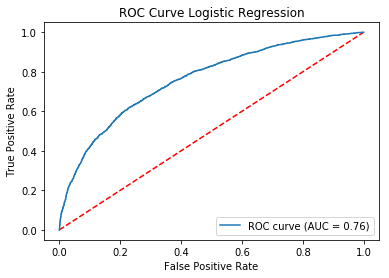

In [135]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

auc = roc_auc_score(y_test, y_pred_prob)
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Logistic Regression')
plt.legend(loc='lower right')
plt.show()

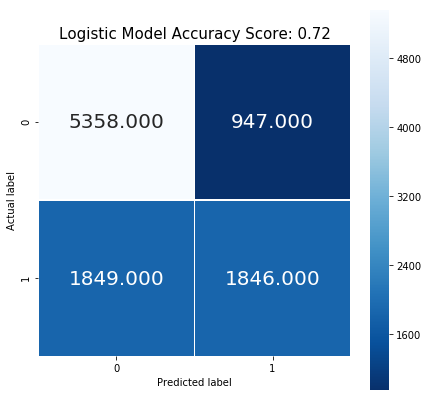

In [136]:
# Compute and visualize confusion matrix 
cm = confusion_matrix(y_test, y_pred_binary)

score = accuracy_score(y_test, y_pred_binary)

plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True,  annot_kws={"size": 20}, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Logistic Model Accuracy Score: {:.2f}'.format(score)

plt.title(all_sample_title, size = 15)
plt.show()

In [137]:
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79      6305
         1.0       0.66      0.50      0.57      3695

   micro avg       0.72      0.72      0.72     10000
   macro avg       0.70      0.67      0.68     10000
weighted avg       0.71      0.72      0.71     10000

